# Off-policy Estimation of a Blackjack State Value

Estimate the value of this state:
- the dealer is showing a deuce
- the sum of the player's cards is 13
- the player has a usable ace

Data was generated by starting at this state then following the behavior policy:
- choose to stick or hit with equal probability

The target policy is also fixed:
- stick only on a sum of 20 or 21

In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from black_jack import BlackjackEnv

In [2]:
def reset_env(env):
    """ Reset env to interested state, return obs
    """
    env.reset()
    player_deck = np.array([
        [1, 1, 1],
        [1, 2]
    ], dtype=object)
    env.player = np.random.choice(player_deck, p=[0.0714, 0.9286])  # (1 / 13) ** 2 / ((1 / 13) ** 2 + (1 / 13) ** 3)
    env.dealer[0] = 2
    
    return env._get_obs()

def behavior_policy(obs):
    return random.choice([0, 1])

def target_policy(obs):
    return 0 if obs[1] + 12 >= 20 else 1

def generate_episode(env, policy):
    episode = []
    obs = reset_env(env)
    while True:
        act = policy(obs)
        next_obs, reward, done, _ = env.step(act)
        episode.append([obs, act, reward])
        if done:
            break
        else:
            obs = next_obs
    return episode

In [3]:
env = BlackjackEnv()
evaluated_state = (1, 1, 1)
gamma = 1

In [4]:
# Compute target state value
gains = []
episode_num = int(1e6)
for _ in tqdm(range(episode_num)):
    episode = []
    obs = reset_env(env)
    while True:
        act = target_policy(obs)
        next_obs, reward, done, _ = env.step(act)
        episode.append([obs, act, reward])
        if done:
            break
        else:
            obs = next_obs
    gain = 0
    for obs, act, reward in reversed(episode):
        gain = gamma * gain + reward
        if obs == evaluated_state:
            gains.append(gain)
            
target_value = np.mean(gains)
print(target_value)  # In original book it was -0.27726

100%|██████████| 1000000/1000000 [01:43<00:00, 9703.07it/s]


-0.27926


In [5]:
def run(episode_num=10000):
    values = []
    value_ordinary = 0
    total_count = 0
    value_weighted = 0
    total_weight = 0

    for _ in range(episode_num):
        episode = generate_episode(env, behavior_policy)

        gain = 0
        weight = 1
        for obs, act, reward in reversed(episode):
            gain = gamma * gain + reward
            if obs == evaluated_state:
                total_count += 1
                value_ordinary = value_ordinary + (weight / total_count) * (gain - value_ordinary)

                total_weight += weight
                value_weighted = value_weighted + (weight / total_weight) * (gain - value_weighted)

            if act == target_policy(obs):
                pi_prob = 1
            else:
                pi_prob = 0
            b_prob = 0.5
            weight = weight * (pi_prob / b_prob)
            if weight == 0:
                break
        
        values.append([value_ordinary, value_weighted])
    return np.array(values)

In [6]:
runs = 100
mse = None

for i in tqdm(range(runs)):
    values = run()
    square_error = np.square(values - target_value)
    if mse is not None:
        mse += square_error
    else:
        mse = square_error

mse /= runs

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


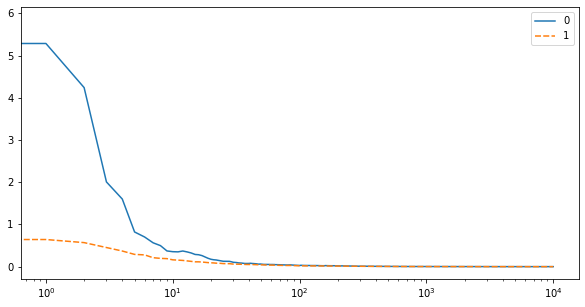

In [7]:
f, ax = plt.subplots(figsize=(10, 5))
ax.set(xscale="log")
df = pd.DataFrame(mse)
sns.lineplot(data=df)